In [168]:
import logging, sys
import numpy as np
sys.path.insert(0, "../..")
import scirpy as ir
import scanpy as sc
from statistics import mean
from glob import glob
import pandas as pd
import tarfile
import anndata
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from numba import NumbaPerformanceWarning


## Since we have debugged the code and know that everything works fine, we now supress all kinds of unwanted messages generated
## and only keep the printed or necessary results. This is for the purpose of better readability of the .pdf report generated.

import warnings
warnings.simplefilter('ignore')

logging.disable(sys.maxsize)
## ignore numba performance warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

## suppress "storing XXX as categorical" warnings.
anndata.logging.anndata_logger.setLevel("ERROR")

In [28]:
annotated = sc.read('/scratch/annotated_umap.h5ad')
genes_and_pseudotime = pd.read_csv('/scratch/genes_and_peudotime.txt',sep=' ')

In [75]:
diff_exp_genes = genes_and_pseudotime['genes']
pseudotime_cluster_order = [genes_and_pseudotime['order'].loc[i] for i in range(len(set(genes_and_pseudotime['order'])))]
pseudotime_ordered_clusters = [annotated[annotated.obs['leiden_number']==str(order)].obs['leiden'].iloc[1] for order in pseudotime_cluster_order]

In [76]:
# find the coordinate of the centroid of each cluster
cluster_centroid = {}
for cluster in set(annotated.obs['leiden']):
    cluster_centroid_x = mean(coord[0] for coord in annotated[annotated.obs['leiden']==cluster].obsm['X_umap'])
    cluster_centroid_y = mean(coord[1] for coord in annotated[annotated.obs['leiden']==cluster].obsm['X_umap'])
    cluster_centroid[cluster] = (cluster_centroid_x, cluster_centroid_y)

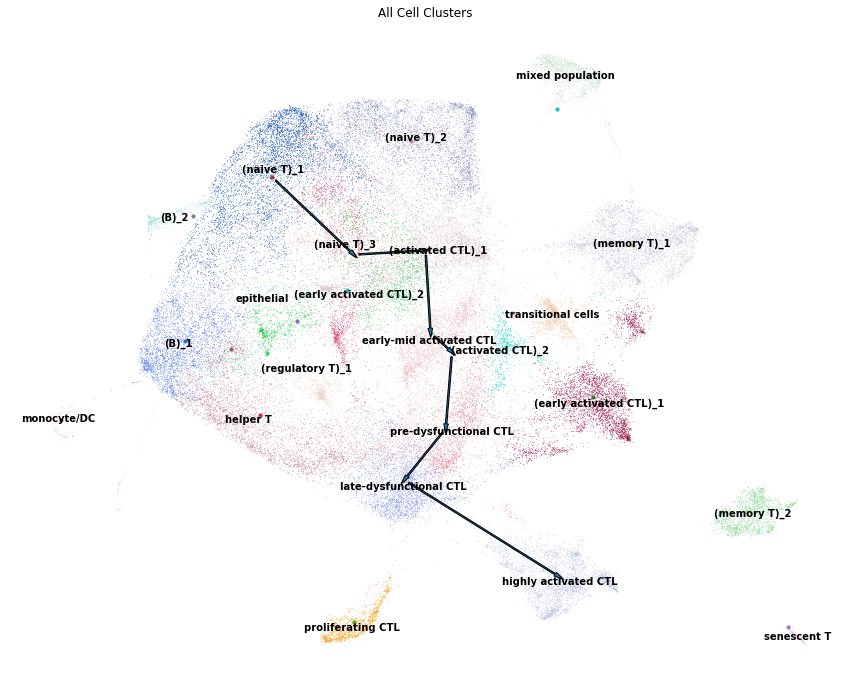

In [127]:
# plotting the trajectory on top of the UMAP
fig, ax = plt.subplots(figsize=(15,12))
for cluster in cluster_centroid:
    ax.scatter(cluster_centroid[cluster][0],cluster_centroid[cluster][1],s=10)
# use arrow to connect consecuitive clusters along the trajectory
for i in range(len(pseudotime_cluster_order)-1):
    start_x, start_y = cluster_centroid[pseudotime_ordered_clusters[i]]
    end_x, end_y = cluster_centroid[pseudotime_ordered_clusters[i+1]]
    dx, dy = (end_x-start_x, end_y-start_y)
    ax.arrow(start_x, start_y, dx, dy,width=0.03,length_includes_head=True,head_starts_at_zero=True,head_length=0.2)   
sc.pl.umap(annotated, color='leiden', title='All Cell Clusters', legend_loc='on data',frameon=False,ax=ax)

## Differential expression analysis along trajectory

In [300]:
expression_matrix = pd.read_csv('/scratch/trajectory_expression_data/exprMatrix.tsv',sep='\t',index_col=0)

# since not every cluster we selected to make trajectory analysis is guaranteed to show up in a single trajectory, we
# subset the cells that is actually on this trajectory
tmp = expression_matrix.T
tmp['cell'] = tmp.index
tmp = tmp.set_index('leiden').loc[pseudotime_ordered_clusters]
tmp['leiden'] = tmp.index
tmp = tmp.set_index('cell')
expression_matrix = tmp

We write a function to plot a heat map for cluster-level average expression of all differentially expressed genes along a trajectory where x-axis are cell clusters in pseudotemporal order, y-axis are genes. The function relies on seaborn.clustermap.
Here are the input:

anndata: scanpy object that containes all necessary information 

trajectory_expression_matrix: the expression matrix of cells and genes along the trajectory

diff_exp_genes: the differentially expressed genes that are detected by pseudotime analysis softwares

rescale: if True, all positive values will be scaled between 0 and 1, all negative values will be scaled between -1 and 0. The scaling method is, for positive expression value x: x/max_x; for negative expression value x: -(x/min_x) where max_x and min_x are the maximum and minimum expression of a gene across all involved cells along trajectory.

In [378]:
def trajectory_diff_exp_genes_heatmap(anndata, trajectory_expression_matrix, pseudotime_ordered_clusters, diff_exp_genes, rescale=False):
    import pandas as pd
    import seaborn as sns
    import copy
    
    # extract genes of interest
    expression_matrix = expression_data.loc[diff_exp_genes]

    # add cluster assignment of each cells to expression_data
    cluster_assignment = pd.DataFrame(annotated.obs['leiden']).T
    expression_matrix = pd.concat([expression_data, cluster_assignment])
    
    # order cells according to pseudotime ordering of the clusters
    #cell_ordering = pd.DataFrame(columns=expression_matrix.index, index=['cluster_order'])
    #for cell in cell_ordering.columns:
    #    cell_ordering[cell] = pseudotime_ordered_clusters.index(expression_matrix.loc['leiden'][cell])
    #expression_matrix = pd.concat([expression_matrix.T, cell_ordering])
    #expression_matrix = expression_matrix.T.sort_values(by='cluster_order').T
    #expression_matrix = expression_matrix.iloc[:-1]
    
    # get the cluster average of all cells
    tmp = expression_matrix.T
    cluster_avg_expression = pd.DataFrame(index=expression_matrix.index)
    for cluster in pseudotime_ordered_clusters:
        cluster_expression_matrix = tmp[tmp['leiden']==cluster].T
        cluster_avg_expression[cluster] = cluster_expression_matrix.drop('leiden',axis=0).mean(axis=1)
    cluster_avg_expression = cluster_avg_expression.drop('leiden',axis=0)
    
    # using the first naive cluster as the base level
    tmp = cluster_avg_expression
    naive_cluster = cluster_avg_expression.columns[0]
    for cluster in cluster_avg_expression.columns:
        tmp[cluster] = cluster_avg_expression[cluster]-cluster_avg_expression[naive_cluster]
        
    # rescale the gene expression to between -1 and 1
    cluster_avg_expression = copy.deepcopy(tmp)
    if rescale==True:
        tmp['min'] = tmp.min(axis=1)
        tmp['max'] = tmp.max(axis=1)
        for cluster in cluster_avg_expression.columns:
            for gene in cluster_avg_expression.index:
                if cluster_avg_expression.loc[gene][cluster]>0:
                    cluster_avg_expression.loc[gene][cluster] = cluster_avg_expression.loc[gene][cluster]/tmp.loc[gene]['max']
                else:
                    cluster_avg_expression.loc[gene][cluster] = -(cluster_avg_expression.loc[gene][cluster]/tmp.loc[gene]['min'])
        plot = sns.clustermap(cluster_avg_expression, col_cluster=False, figsize=(8,20), cbar_pos= None, yticklabels=1,cmap="vlag")
    else:
        plot = sns.clustermap(cluster_avg_expression, col_cluster=False, figsize=(8,20), cbar_pos= None, yticklabels=1,cmap="mako")

In [381]:
# Now we actually use the function to plot

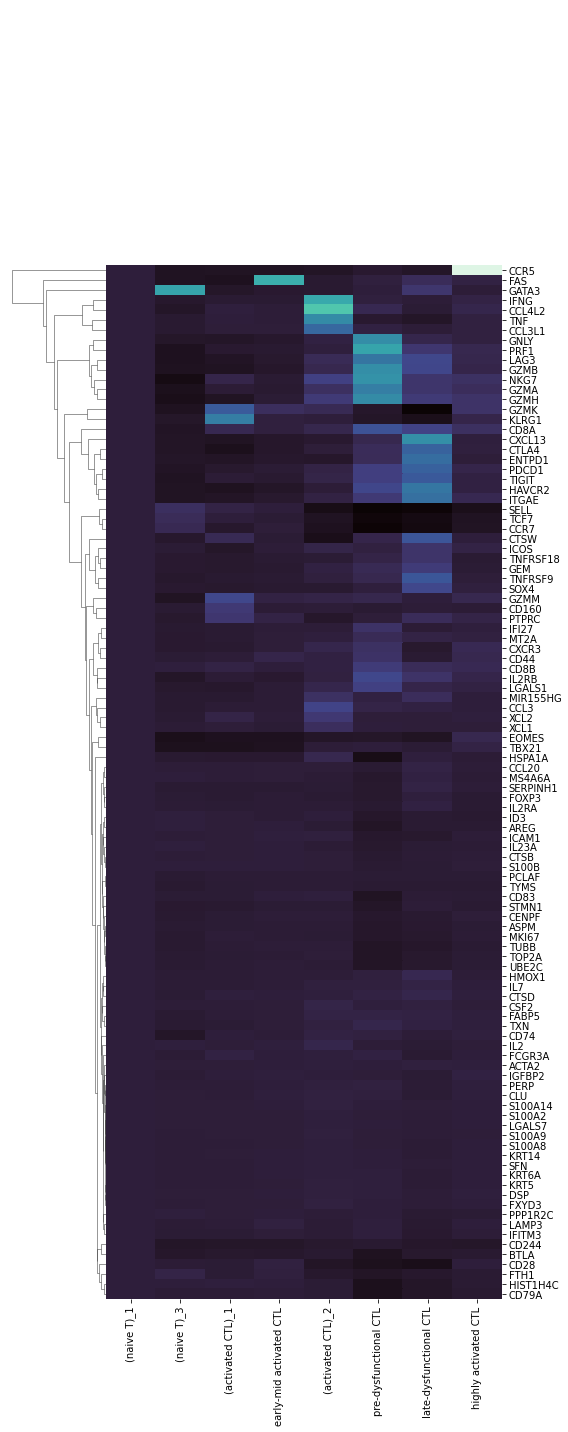

In [380]:
trajectory_diff_exp_genes_heatmap(annotated, expression_matrix, pseudotime_ordered_clusters, diff_exp_genes, rescale=False)